# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy.spatial import ConvexHull
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla
from alens_analysis import physical_scales as ps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

# Data

In [3]:
data_dir_list = {
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001",
}


In [4]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"

# Graphing

## Mean Gaussian contact probability vs bead index

Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Contact Probability')

(1e-09, 2)

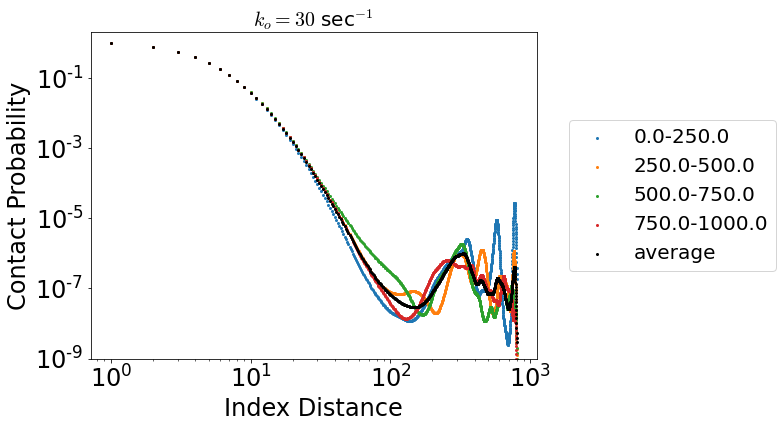

In [87]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Contact Probability')
    _ = axarr.set_ylim(1e-9, 2)
    _ = axarr.set_title(f'$k_o = 30$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




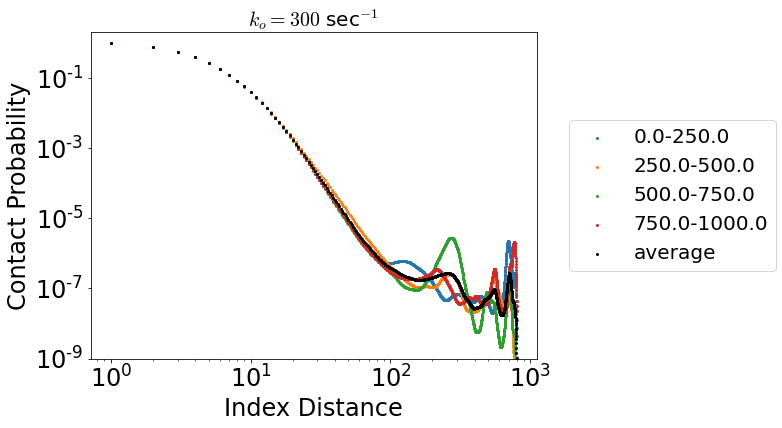

In [88]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Contact Probability')
    _ = axarr.set_title(f'$k_o = 300$ sec$^{{-1}}$')
    _ = axarr.set_ylim(1e-9, 2)
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




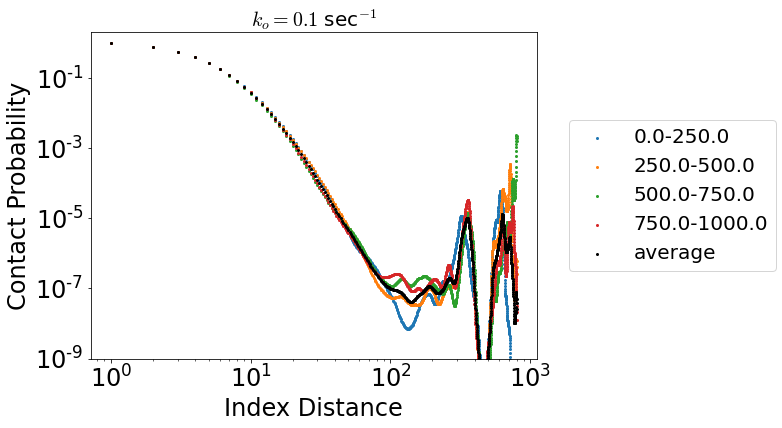

In [89]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Contact Probability')
    _ = axarr.set_title(f'$k_o = 0.1$ sec$^{{-1}}$')
    _ = axarr.set_ylim(1e-9, 2)
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




## Mean distance between beads vs bead index

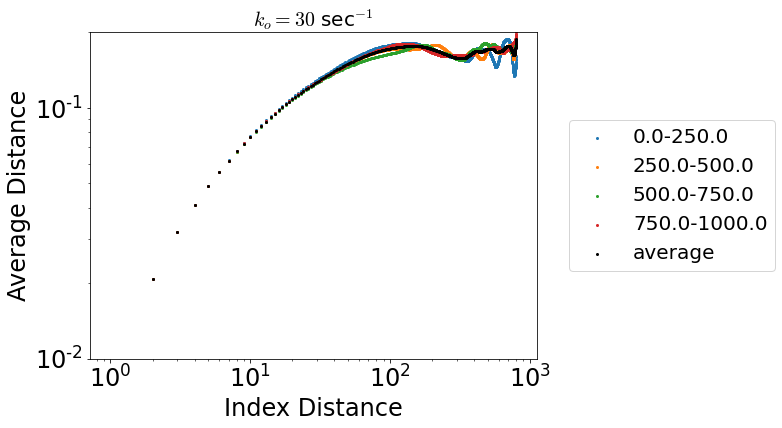

In [7]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 30$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

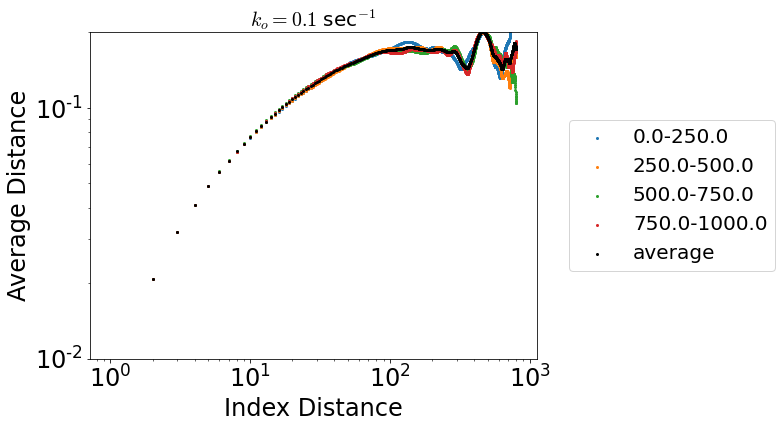

In [9]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 0.1$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

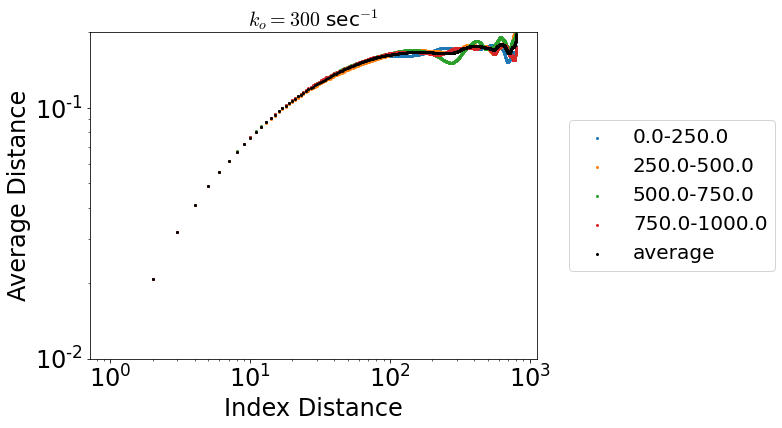

In [10]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 300$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

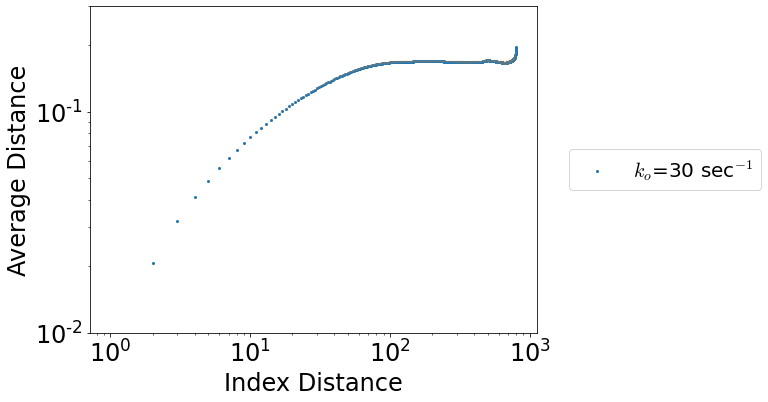

In [45]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
avg_dist_v = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        spring_length = pparams['proteins'][0]['freeLength']

        n_steps = com_arr.shape[2]
        dist_v_arr = [] 
        for i in np.arange(n_steps, step=100):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
avg_dist_std = np.array(avg_dist_v).std(axis=0)
avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
bead_ind_arr = np.arange(avg_dist_mean.size)+1
ci_bound = .95

_ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={30} sec$^{{-1}}$')
ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
_ = axarr.fill_between(bead_ind_arr, 
                    avg_dist_mean - ci, avg_dist_mean + ci, 
                    alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




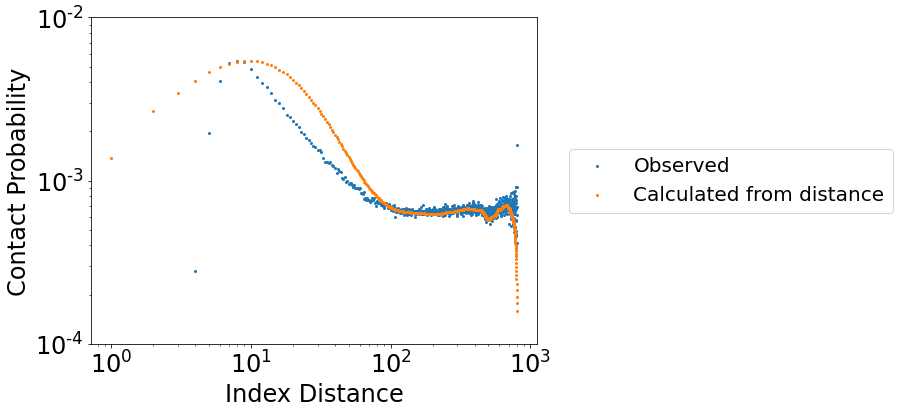

In [60]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
avg_dist_v = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        kbT = rparams['KBT']
        spring_length = pparams['proteins'][0]['freeLength']
        spring_const = pparams['proteins'][0]['kappa']

        n_steps = com_arr.shape[2]
        dist_v_arr = [] 
        for i in np.arange(n_steps, step=100):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
avg_dist_std = np.array(avg_dist_v).std(axis=0)
avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
bead_ind_arr = np.arange(avg_dist_mean.size)+1
ci_bound = .95

axarr.scatter(bead_ind_arr, combined_connect_prob, label=f'Observed')
_ = axarr.scatter(bead_ind_arr, np.max(combined_connect_prob)*np.exp(-np.power(avg_dist_mean - spring_length - .02, 2)/kbT) , label=f'Calculated from distance')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(.0001, .01)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




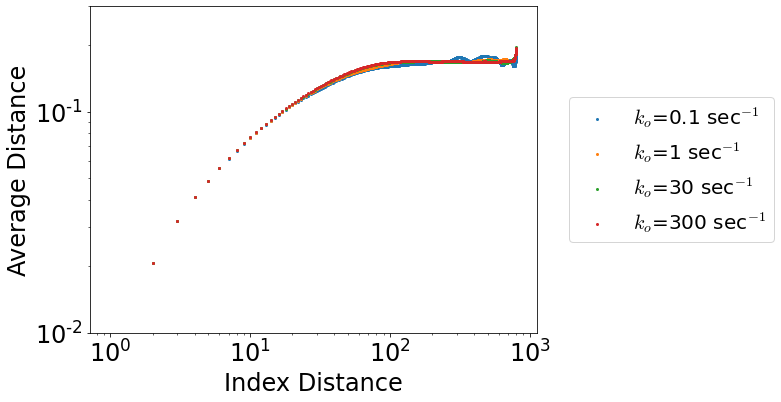

In [ ]:
param_dirs = [cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_dist_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']

            n_steps = com_arr.shape[2]
            dist_v_arr = [] 
            for i in np.arange(n_steps, step=100):
                dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
                dist_v_arr += [dist_v_gd.to('cpu').numpy()]
            avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
    avg_dist_std = np.array(avg_dist_v).std(axis=0)
    avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
    bead_ind_arr = np.arange(avg_dist_mean.size)+1
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$')
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(bead_ind_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[ 3.56063080e+02 -3.04156750e+02  1.66695357e-01]


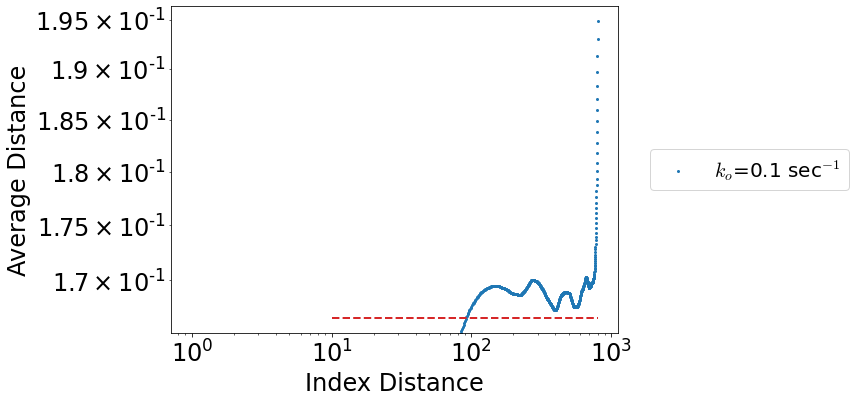

In [36]:
def power_law_func(x, a, b, c):
    return a*np.power(x, b) + c 

param_dirs = [
            #cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_dist_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']

            n_steps = com_arr.shape[2]
            dist_v_arr = [] 
            for i in np.arange(n_steps, step=100):
                dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
                dist_v_arr += [dist_v_gd.to('cpu').numpy()]
            avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
    avg_dist_std = np.array(avg_dist_v).std(axis=0)
    avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
    bead_ind_arr = np.arange(avg_dist_mean.size)+1
    ci_bound = .95
    x = np.arange(10,avg_dist_mean.shape[0])
    popt, pcov = curve_fit(power_law_func, x, avg_dist_mean[10:], p0=(-1, -1.5, 1))
    _ = axarr.plot(x, power_law_func(x, *popt), color='tab:red', ls='--')

    print(popt)

    

    _ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$')
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(bead_ind_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[0.03440121 0.3831578  1.        ]


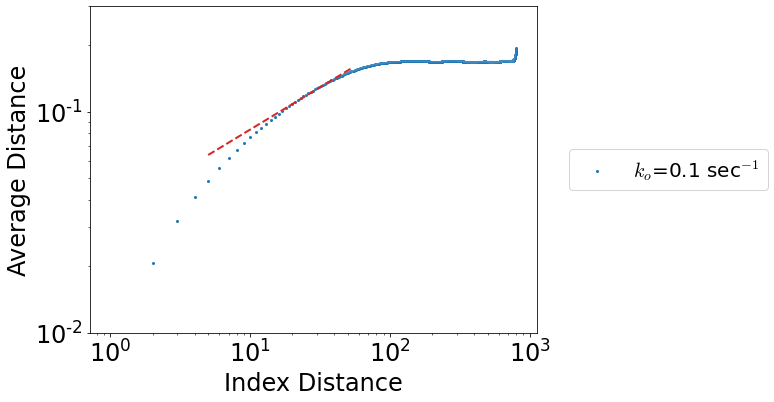

In [50]:
def power_law_func(x, a, b, c):
    return a*np.power(x, b) 
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bead_ind_arr = np.arange(avg_dist_mean.size)+1
ci_bound = .95
x = np.arange(5,avg_dist_mean.shape[0]-100)
popt, pcov = curve_fit(power_law_func, x[:50], avg_dist_mean[5:55], p0=(1, 1, 1))
_ = axarr.plot(x[:50], power_law_func(x[:50], *popt), color='tab:red', ls='--')

print(popt)



_ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$')
ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
_ = axarr.fill_between(bead_ind_arr, 
                    avg_dist_mean - ci, avg_dist_mean + ci, 
                    alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Mean contact between beads vs bead index

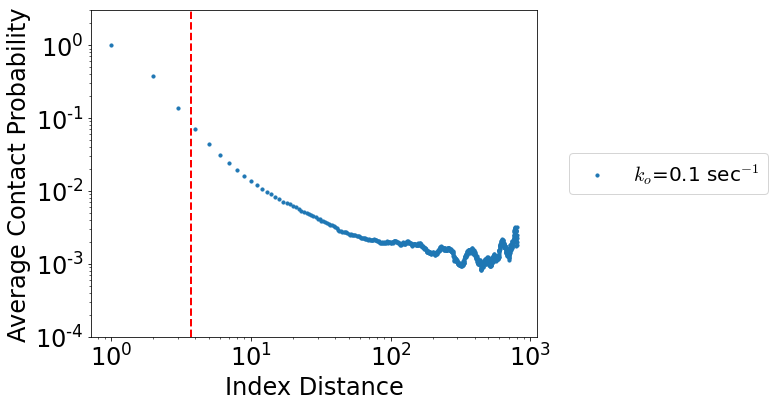

In [24]:
param_dirs = [cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$', s=10)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




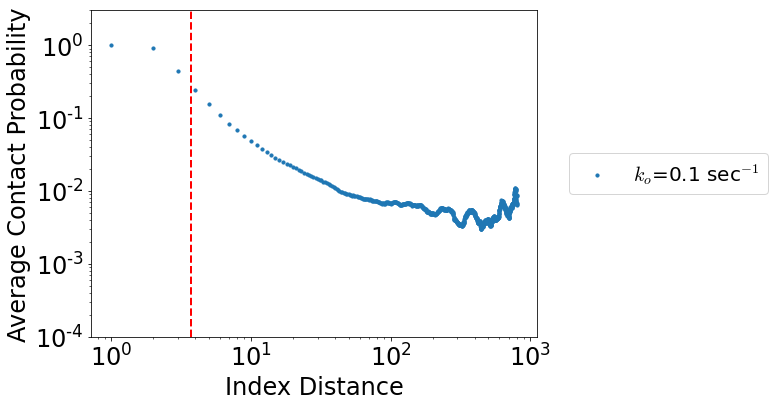

In [23]:
param_dirs = [cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
            #   cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .04)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$', s=10)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




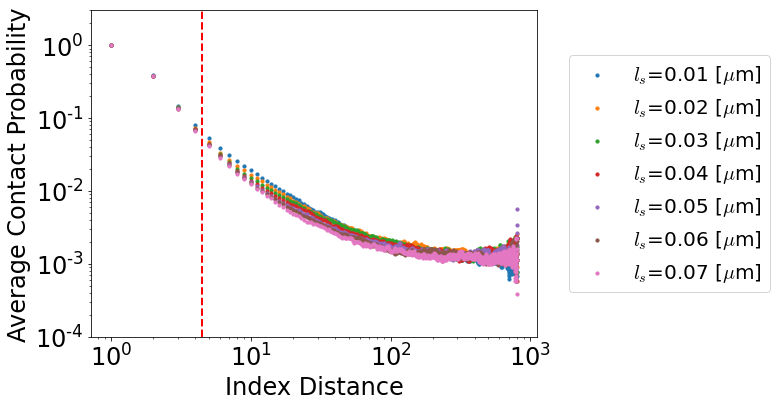

In [27]:
param_dirs = [cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]', s=5)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[ 4.11035933e-01 -1.81632234e+00  1.45463380e-05]
[ 2.95292588e-01 -1.50902031e+00  4.76629940e-04]
[ 3.17782684e-01 -1.51088074e+00  9.11910267e-04]
[ 2.80895874e-01 -1.43159211e+00  1.12872149e-03]
[ 3.15808393e-01 -1.48072823e+00  1.27799357e-03]
[ 2.84907400e-01 -1.42030996e+00  1.32864253e-03]
[ 2.91768309e-01 -1.43521080e+00  1.37186689e-03]


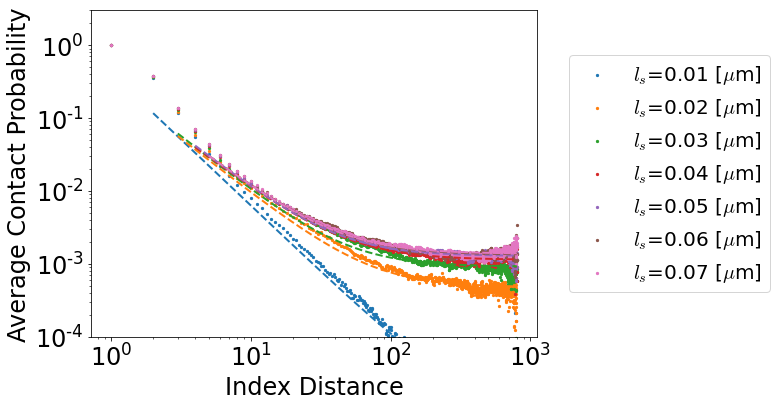

In [35]:
param_dirs = [
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = int(ls_ratio) + 1
    x = np.arange(max_ind,avg_cont_mean.shape[0])
    popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]', s=5)
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
# _ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[ 0.45395419 -2.2026561 ]
[ 0.31432848 -1.80038081]
[ 0.25619192 -1.50247889]
[ 0.24128105 -1.33308801]
[ 0.23859403 -1.27624287]
[ 0.24217051 -1.23100843]
[ 0.24500002 -1.20172757]
[ 0.24809663 -1.18924349]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


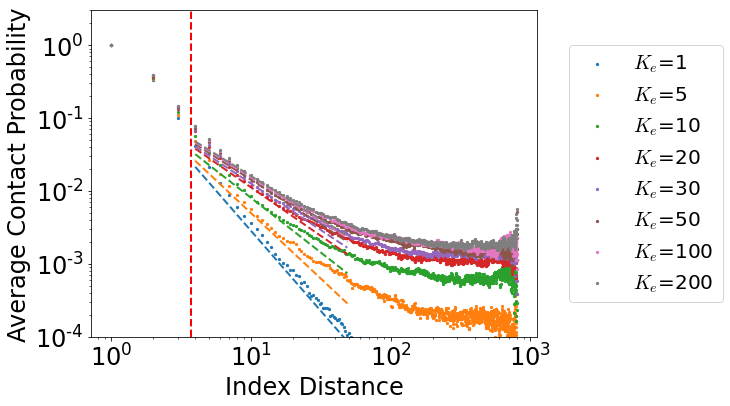

In [3]:
def power_law_func(x, a, b):
    return a*np.power(x, b)

param_dirs = [
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [1, 5, 10, 20, 30, 50, 100, 200]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = int(ls_ratio) + 1
    # max_ind = 10
    #end_ind = avg_cont_mean.shape[0]
    end_ind = 50
    # end_ind = 100
    x = np.arange(max_ind,end_ind)
    popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1))
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$K_e$={val} ', s=5)
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[ 0.39905049 -2.12826425]
[ 0.09256965 -1.31956859]
[ 0.08467734 -1.08653389]
[ 0.09338519 -0.98708691]
[ 0.09875582 -0.95936818]
[ 0.11275819 -0.95786121]
[ 0.11834177 -0.94248527]
[ 0.12066434 -0.93153684]


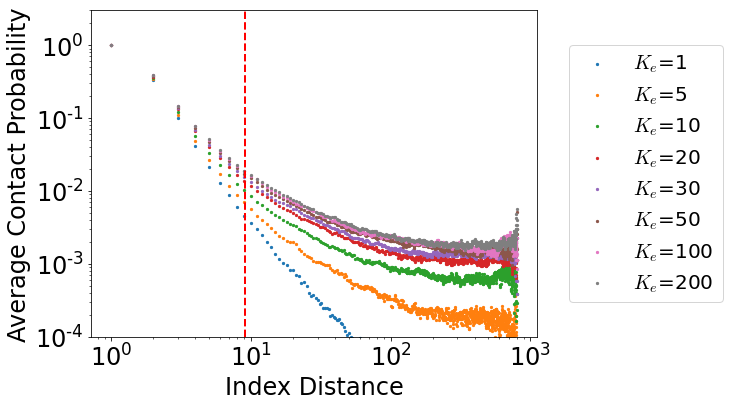

In [22]:
def power_law_func(x, a, b):
    return a*np.power(x, b)

param_dirs = [
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100",
cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
small_saw = 1000
big_saw = 0
for param_dir, val in zip(param_dirs, [1, 5, 10, 20, 30, 50, 100, 200]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length + diam) / diam
            saw_sep = np.power(ls_ratio, 5/3)
            small_saw = saw_sep if saw_sep < small_saw else small_saw
            big_saw = saw_sep if saw_sep > big_saw else big_saw

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = int(saw_sep) + 1
    # max_ind = 10
    #end_ind = avg_cont_mean.shape[0]
    end_ind = 50
    # end_ind = 100
    x = np.arange(max_ind,end_ind)
    popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1))
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    # _ = axarr.plot(x, power_law_func(x, *popt), ls='--')
    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$K_e$={val} ', s=5)
    # _ = axarr.plot(x, power_law_func(x, *popt), ls='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(big_saw, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[ 0.36261768 -1.34076804]
[ 0.21622994 -1.14638695]
[ 0.17197768 -1.08443725]
[ 0.12998934 -1.01442398]
[ 0.11344463 -1.00134163]
[ 0.10367415 -0.9891623 ]
[ 0.08582937 -0.95990766]


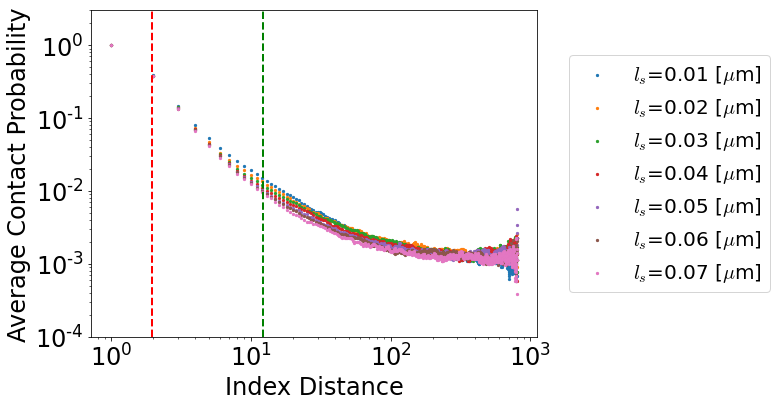

In [19]:
def power_law_func(x, a, b):
    return a*np.power(x, b)
param_dirs = [cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
small_saw = 1000
big_saw = 0
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length + diam) / diam
            saw_sep = np.power(ls_ratio, 5/3)
            small_saw = saw_sep if saw_sep < small_saw else small_saw
            big_saw = saw_sep if saw_sep > big_saw else big_saw

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = int(saw_sep) + 1
    # max_ind = 10
    #end_ind = avg_cont_mean.shape[0]
    end_ind = 50
    # end_ind = 100
    x = np.arange(max_ind,end_ind)
    popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1))
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    # _ = axarr.plot(x, power_law_func(x, *popt), ls='--')

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]', s=5)
    # _ = axarr.plot(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(small_saw, color='r', ls='--')
_ = axarr.axvline(big_saw, color='g', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




Short
[ 0.30891634 -1.2805771 ]
Short
[ 0.27460954 -1.29254419]
Short
[ 0.30258761 -1.38775184]
[ 0.37821063 -1.54472912]
[ 0.34569142 -1.50724127]
[ 0.3389445  -1.50165337]
[ 0.31408186 -1.47918811]


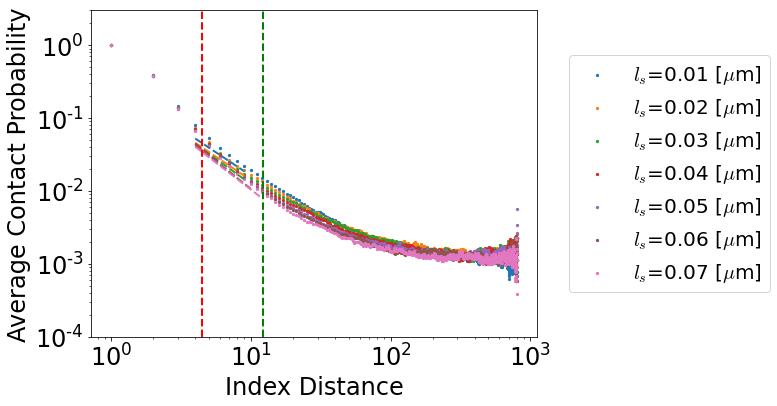

In [13]:
def power_law_func(x, a, b):
    return a*np.power(x, b)
param_dirs = [cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length + diam) / diam
            saw_sep = np.power(ls_ratio, 5/3)

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = 5 
    end_ind = int(saw_sep) + 1
    if max_ind >= end_ind - 2:
        print("Short")
        end_ind = 10

    x = np.arange(max_ind,end_ind)
    popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1))
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]', s=5)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.axvline(saw_sep, color='g', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




KeyboardInterrupt: 

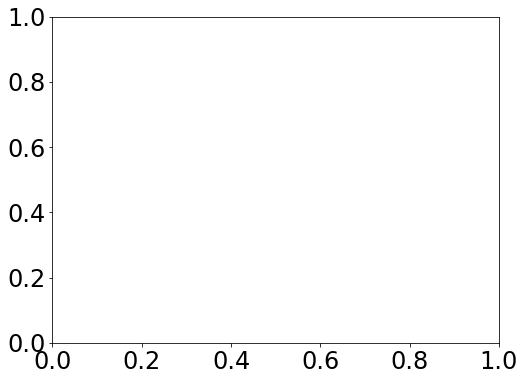

In [24]:
def power_law_func(x, a, b):
    return a*np.power(x, b)
def linear_func(x, a, b):
    return a*x + b
param_dirs = [cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length + diam) / diam
            saw_sep = np.power(ls_ratio, 5/3)

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .03)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    max_ind = 5 
    end_ind = int(saw_sep) + 1
    if max_ind >= end_ind - 2:
        print("Short")
        end_ind = 10

    x = np.arange(max_ind,end_ind)
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1))
    popt, pcov = curve_fit(linear_func, np.log(x), np.log(avg_cont_mean[max_ind:end_ind]), p0=(1, -1))
    # popt, pcov = curve_fit(power_law_func, x, avg_cont_mean[max_ind:end_ind], p0=(1, -1, .1))
    print(popt)
    # popt_list += [popt]
    # pcov_list += [np.sqrt(np.diag(pcov))[1]]
    _ = axarr.plot(x, np.exp(linear_func(np.log(x), *popt)), ls='--')

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} [$\mu$m]', s=5)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.axvline(saw_sep, color='g', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




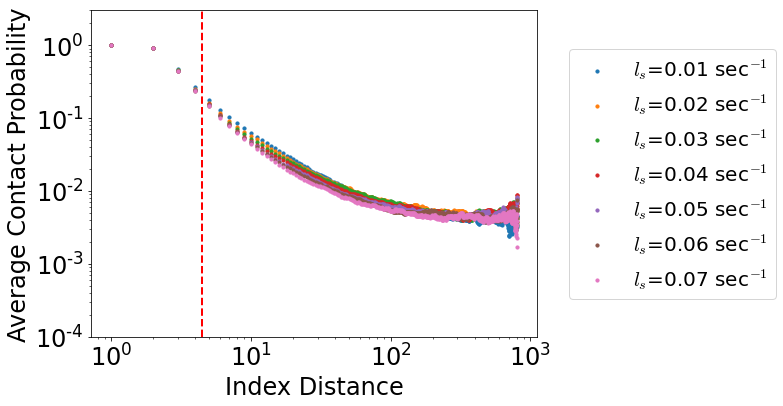

In [26]:
param_dirs = [
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06",
    cond_path / "23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [.01, .02, .03, .04, .05, .06, .07]):
    avg_cont_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']
            diam = 2. * sy_dat[0,1,0]
            ls_ratio = (spring_length+ diam) / diam 

            n_steps = com_arr.shape[2]
            cont_v_arr = [] 
            for i in np.arange(n_steps, step=50):
                cont_v_gd = cps.contact_vs_idx_dist(com_arr[:,:, i], .04)
                cont_v_arr += [cont_v_gd.to('cpu').numpy()]
            avg_cont_v += [np.mean(np.array(cont_v_arr), axis=0)]
    avg_cont_std = np.array(avg_cont_v).std(axis=0)
    avg_cont_mean = np.array(avg_cont_v).mean(axis=0)
    bead_ind_arr = np.arange(1, avg_cont_mean.size+1)
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_cont_mean, label=f'$l_s$={val} $\mu$m', s=10)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-4, 3)
_ = axarr.axvline(ls_ratio, color='r', ls='--')
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




## Mean connection vs bead index

In [80]:
def graph_connect_prob_no_const(data_path_list, axarr, divide_by_time=False, divide_by_max=False):
    def power_law_func(x, a, b, c):
        return a*np.power(x, b) + c 
    for data_path in data_path_list: 
        avg_cnt_list = []
        for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
            with h5py.File(dp, 'r') as h5_cnct:
                acm = h5_cnct['avg_connect_mat'][...]
                time_arr = h5_cnct['time'][...]

                avg_connect_vs_ind = np.zeros(acm.shape[0])
                for i in range(1, acm.shape[0]):
                    avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                    avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                    avg_connect_vs_ind[i] *= .5
                avg_cnt_list += [avg_connect_vs_ind]
        cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)
        if divide_by_time:
            cnt_vs_ind_arr /= time_arr.size
        if divide_by_max:
            cnt_vs_ind_arr /= np.amax(cnt_vs_ind_arr)
            
        max_ind = np.argmax(cnt_vs_ind_arr)+2

        x = np.arange(max_ind,acm.shape[0])
        popt, pcov = curve_fit(power_law_func, x, cnt_vs_ind_arr[max_ind:], p0=(1, -1, .1))

        _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:]-popt[2])
        print(popt)
        x = np.arange(3,acm.shape[0])
    _ = axarr.plot(x[:100], power_law_func(x[:100], popt[0]+.1,-1.5, 0 ), ls='--', c='k')   
    _ = axarr.set_ylim(.00001, .05)
    if divide_by_max:
        _ = axarr.set_ylim(.001, 1.)
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('$|i-j|$')
    _ = axarr.set_ylabel('$P_c - P_c^o$')


def graph_connect_prob_vs_index(data_path_list, axarr, divide_by_time=False,):
    def power_law_func(x, a, b, c):
        return a*np.power(x, b) + c 
    popt_list = []
    pcov_list = []
    for data_path in data_path_list: 
        avg_cnt_list = []
        for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
            with h5py.File(dp, 'r') as h5_cnct:
                acm = h5_cnct['avg_connect_mat'][...]
                time_arr = h5_cnct['time'][...]

                avg_connect_vs_ind = np.zeros(acm.shape[0])
                for i in range(1, acm.shape[0]):
                    avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                    avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                    avg_connect_vs_ind[i] *= .5
                avg_cnt_list += [avg_connect_vs_ind]
        cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)
        if divide_by_time:
            cnt_vs_ind_arr /= time_arr.sizes

        max_ind = np.argmax(cnt_vs_ind_arr)+2
        x = np.arange(max_ind,acm.shape[0])
        popt, pcov = curve_fit(power_law_func, x, cnt_vs_ind_arr[max_ind:], p0=(1, -1, .1))
        popt_list += [popt]
        pcov_list += [np.sqrt(np.diag(pcov))[1]]

        _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:])
        _ = axarr.plot(x, power_law_func(x, popt[0],popt[1], popt[2] ), ls='--')
        print(popt)
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_ylim(.00001, .05)
    _ = axarr.set_xlabel('$|i-j|$')
    _ = axarr.set_ylabel('$P_c$')
    return np.array(popt_list), np.array(pcov_list)

[ 7.85276359e-02 -1.30063266e+00  6.02192181e-04]
[ 9.82058611e-02 -1.39556616e+00  6.20075766e-04]
[ 8.80191168e-02 -1.34802921e+00  5.92688771e-04]
[ 8.72701530e-02 -1.34068202e+00  5.97678082e-04]
[ 8.05254418e-02 -1.32245242e+00  5.75320877e-04]
[ 1.21461156e-01 -1.48313830e+00  6.31216977e-04]
[ 1.03858990e-01 -1.42038448e+00  6.38852490e-04]
[ 1.16026121e-01 -1.46672195e+00  6.27652298e-04]


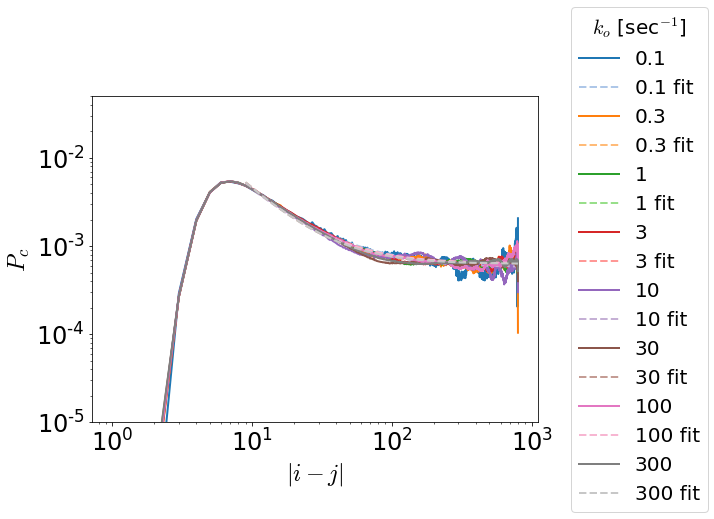

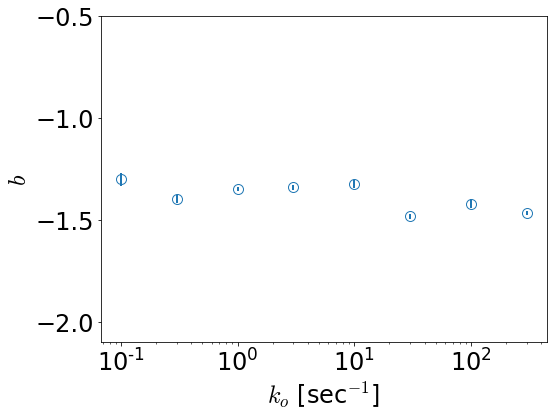

In [102]:
data_path_list = [
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod3/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod10/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod100/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300/"
                ]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
popt, pcov = graph_connect_prob_vs_index(data_path_list, axarr, divide_by_time=True)

_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$k_o$ [sec$^{-1}$]', labels=['0.1', '0.1 fit', 
                                                                                                   '0.3', '0.3 fit', 
                                                                                                   '1'  , '1 fit', 
                                                                                                   '3'  , '3 fit', 
                                                                                                   '10' , '10 fit', 
                                                                                                   '30' , '30 fit', 
                                                                                                   '100', '100 fit',
                                                                                                   '300', '300 fit',
                                                                                                   ])
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
vals = [0.1, 0.3, 1 , 3 , 10, 30, 100, 300]
_ = axarr.errorbar(vals, popt[:,1], yerr=pcov, fmt='o', ls='none', fillstyle='none', markersize=10)
_ = axarr.set_xlabel('$k_o$ [sec$^{-1}$]')
_ = axarr.set_ylabel('$b$')
_ = axarr.set_ylim(-2.1, -.5)
_ = axarr.set_xscale('log')

[ 1.27777170e-01 -2.05922190e+00  3.75965729e-06]
[ 1.03120888e-01 -1.60405270e+00  1.30174082e-04]
[ 9.81373851e-02 -1.45856551e+00  2.83806285e-04]
[ 9.74900647e-02 -1.40715977e+00  4.22419007e-04]
[ 9.57825521e-02 -1.39596333e+00  5.34924539e-04]
[ 8.75951225e-02 -1.35252991e+00  6.27257483e-04]
[ 8.60237293e-02 -1.36551351e+00  7.03212907e-04]


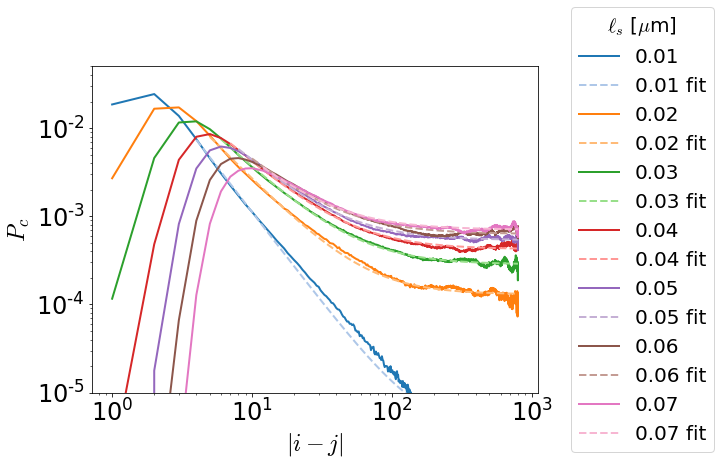

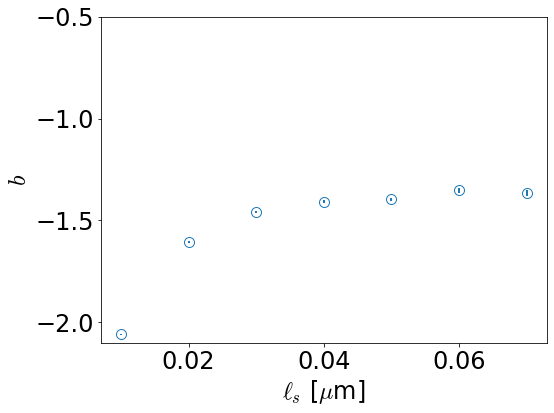

In [101]:
data_path_list = [
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.01/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/',
                ]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


popt, pcov = graph_connect_prob_vs_index(data_path_list, axarr, divide_by_time=True)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$\ell_s$ [$\mu$m]', 
                 labels=['0.01','0.01 fit', 
                         '0.02', '0.02 fit', 
                         '0.03', '0.03 fit', 
                         '0.04', '0.04 fit', 
                         '0.05', '0.05 fit', 
                         '0.06', '0.06 fit', 
                         '0.07', '0.07 fit'])
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06 , 0.07]
_ = axarr.errorbar(vals, popt[:,1], yerr=pcov, fmt='o', ls='none', fillstyle='none', markersize=10)
_ = axarr.set_xlabel('$\ell_s$ [$\mu$m]')
_ = axarr.set_ylabel('$b$')
_ = axarr.set_ylim(-2.1, -.5)

[ 2.36386853e-02 -1.88091231e+00 -3.30441042e-07]
[ 4.18142265e-02 -1.44474073e+00  6.68698562e-05]
[ 7.06169437e-02 -1.45937322e+00  2.63098824e-04]
[ 8.53637015e-02 -1.39542552e+00  4.70934989e-04]
[ 1.01568625e-01 -1.41750630e+00  5.96937224e-04]
[ 8.76998148e-02 -1.30702191e+00  6.74485836e-04]
[ 1.21945817e-01 -1.40610231e+00  8.38540678e-04]
[ 1.19825337e-01 -1.37740123e+00  8.93426658e-04]


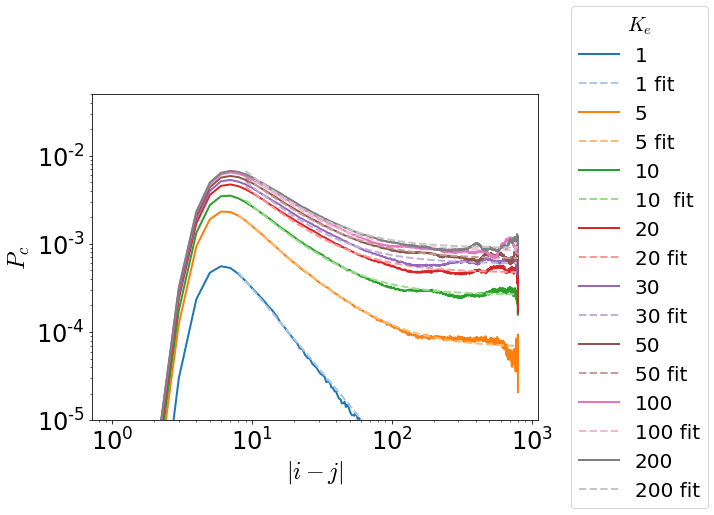

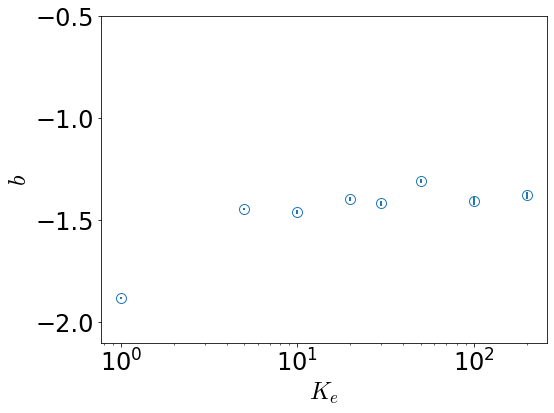

In [100]:
data_path_list = [
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
popt, pcov = graph_connect_prob_vs_index(data_path_list, axarr, divide_by_time=True)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', 
                                        labels=[1, "1 fit",
                                                5,"5 fit", 
                                                10, "10  fit",
                                                20, "20 fit", 
                                                30, "30 fit", 
                                                50, "50 fit", 
                                                100, "100 fit", 
                                                200, "200 fit",
                                                                ])
_ = axarr.set_ylim(.00001, .05)

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
vals = [1, 5, 10, 20, 30, 50, 100, 200] 
_ = axarr.errorbar(vals, popt[:,1], yerr=pcov, fmt='o', ls='none', fillstyle='none', markersize=10)
_ = axarr.set_xlabel('$K_e$')
_ = axarr.set_ylabel('$b$')
_ = axarr.set_ylim(-2.1, -.5)
_ = axarr.set_xscale('log')
                                                                

[ 7.85276359e-02 -1.30063266e+00  6.02192181e-04]
[ 9.82058611e-02 -1.39556616e+00  6.20075766e-04]
[ 8.80191168e-02 -1.34802921e+00  5.92688771e-04]
[ 8.72701530e-02 -1.34068202e+00  5.97678082e-04]
[ 8.05254418e-02 -1.32245242e+00  5.75320877e-04]
[ 1.21461156e-01 -1.48313830e+00  6.31216977e-04]
[ 1.03858990e-01 -1.42038448e+00  6.38852490e-04]
[ 1.16026121e-01 -1.46672195e+00  6.27652298e-04]


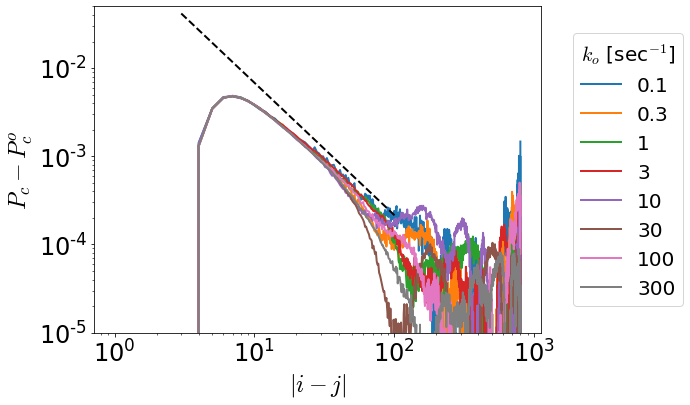

In [71]:
data_path_list = [
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod3/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod10/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod100/",
                cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300/"
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_connect_prob_no_const(data_path_list, axarr, divide_by_time=True)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$k_o$ [sec$^{-1}$]', labels=['0.1', 
                                                                                                   '0.3', 
                                                                                                   '1'  , 
                                                                                                   '3'  , 
                                                                                                   '10' , 
                                                                                                   '30' , 
                                                                                                   '100', 
                                                                                                   '300', 
                                                                                                   ])


[ 2.36386853e-02 -1.88091231e+00 -3.30441042e-07]
[ 4.18142265e-02 -1.44474073e+00  6.68698562e-05]
[ 7.06169437e-02 -1.45937322e+00  2.63098824e-04]
[ 8.53637015e-02 -1.39542552e+00  4.70934989e-04]
[ 1.01568625e-01 -1.41750630e+00  5.96937224e-04]
[ 8.76998148e-02 -1.30702191e+00  6.74485836e-04]
[ 1.21945817e-01 -1.40610231e+00  8.38540678e-04]
[ 1.19825337e-01 -1.37740123e+00  8.93426658e-04]


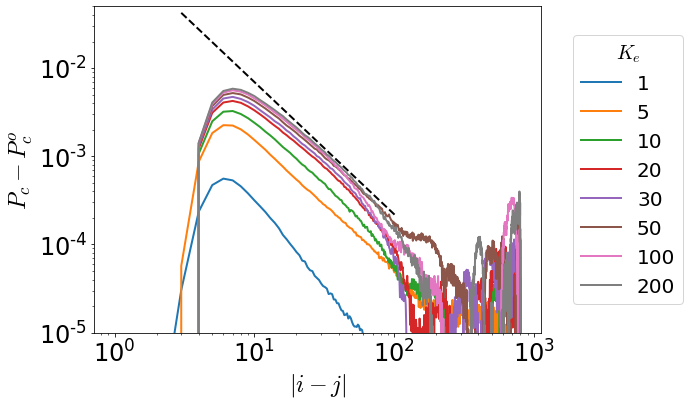

In [72]:
data_path_list = [
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_connect_prob_no_const(data_path_list, axarr, divide_by_time=True)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', 
                                                                labels=[1, 
                                                                        5, 
                                                                        10,
                                                                        20,
                                                                        30,
                                                                        50,
                                                                        100, 
                                                                        200,
                                                                        ])



[ 1.27777170e-01 -2.05922190e+00  3.75965729e-06]
[ 1.03120888e-01 -1.60405270e+00  1.30174082e-04]
[ 9.81373851e-02 -1.45856551e+00  2.83806285e-04]
[ 9.74900647e-02 -1.40715977e+00  4.22419007e-04]
[ 9.57825521e-02 -1.39596333e+00  5.34924539e-04]
[ 8.75951225e-02 -1.35252991e+00  6.27257483e-04]
[ 8.60237293e-02 -1.36551351e+00  7.03212907e-04]


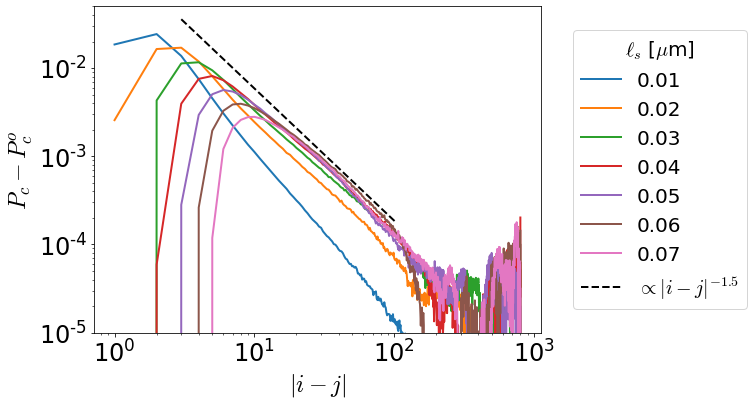

In [ ]:
data_path_list = [
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.01/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06/',
                cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/',
                ]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


graph_connect_prob_no_const(data_path_list, axarr, divide_by_time=True)
_ = axarr.set_ylim(.00001, .05)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$\ell_s$ [$\mu$m]', 
                 labels=['0.01',
                         '0.02', 
                         '0.03', 
                         '0.04', 
                         '0.05', 
                         '0.06', 
                         '0.07',
                         '$\propto |i-j|^{-1.5}$'])


[ 5.47407089e+01 -1.97175981e+00 -2.23818896e-04]
[19.38483523 -1.4690247   0.0291739 ]
[22.21015842 -1.49227753  0.07514469]
[20.50871063 -1.43459507  0.10058676]
[22.04130171 -1.46237778  0.11304583]
[16.54671349 -1.34000402  0.11532293]
[22.08591544 -1.45439723  0.13100904]
[20.69765005 -1.42465587  0.13353989]


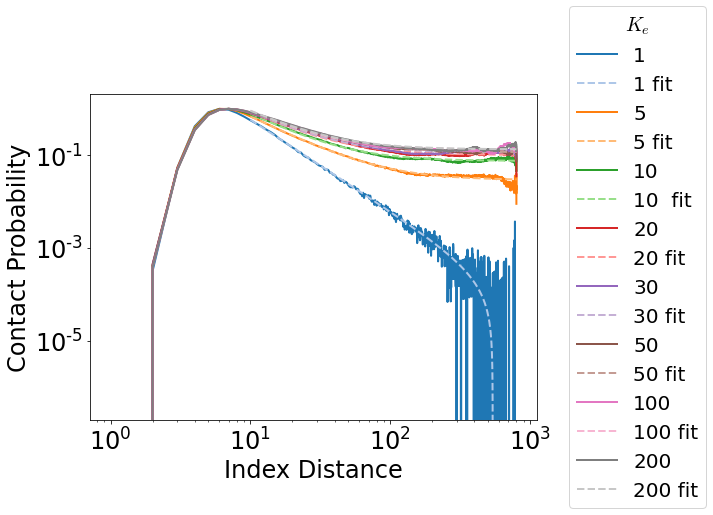

In [7]:
def power_law_func(x, a, b, c):
    return a*np.power(x, b) + c

data_path_list = [
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

for data_path in data_path_list: 
    avg_cnt_list = []
    for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
        with h5py.File(dp, 'r') as h5_cnct:
            acm = h5_cnct['avg_connect_mat'][...]
            time_arr = h5_cnct['time'][...]

            avg_connect_vs_ind = np.zeros(acm.shape[0])
            for i in range(1, acm.shape[0]):
                avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                avg_connect_vs_ind[i] *= .5
            avg_cnt_list += [avg_connect_vs_ind]
    cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)/time_arr.size
    # cnt_vs_ind_arr /= np.amax(cnt_vs_ind_arr)
    x = np.arange(10,acm.shape[0])
    popt, pcov = curve_fit(power_law_func, x, cnt_vs_ind_arr[10:], p0=(10, -1, .1))

    _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:])
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')
    print(popt)

# _ = axarr.plot(x, 5./x + .1, c='k', ls='--')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ = axarr.set_ylim(.00001, .05)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', labels=[1, "1 fit",
                                                                                      5,"5 fit", 
                                                                                      10, "10  fit",
                                                                                      20, "20 fit", 
                                                                                      30, "30 fit", 
                                                                                      50, "50 fit", 
                                                                                      100, "100 fit", 
                                                                                      200, "200 fit",
                                                                                      ])


[ 8.79600908e-03 -2.53311794e+00  2.85105115e-08]
[ 1.77867126e-02 -2.54468943e+00  7.80413907e-08]
[ 3.83960539e-02 -2.45054681e+00  1.39744931e-07]
[ 6.62874656e-02 -2.35670665e+00  3.20918735e-07]
[ 9.75781333e-02 -2.15820271e+00  9.86252139e-07]
[ 1.02997242e-01 -1.68530479e+00  3.20065344e-05]
[ 1.27532449e-01 -1.59760816e+00  2.13816183e-04]
[ 1.44607324e-01 -1.54421768e+00  3.39085554e-04]


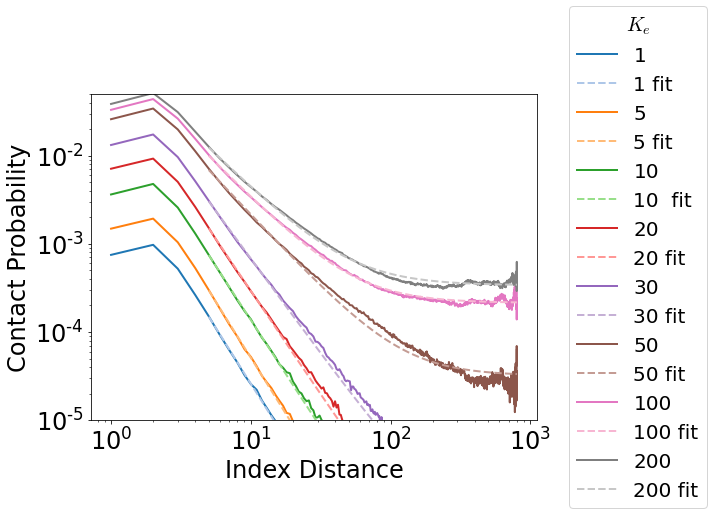

In [24]:
data_path_list = [ 
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke1/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke2/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke5/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke10/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke20/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke50/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke100/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.01_Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for data_path in data_path_list: 
    avg_cnt_list = []
    for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
        with h5py.File(dp, 'r') as h5_cnct:
            acm = h5_cnct['avg_connect_mat'][...]
            time_arr = h5_cnct['time'][...]

            avg_connect_vs_ind = np.zeros(acm.shape[0])
            for i in range(1, acm.shape[0]):
                avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                avg_connect_vs_ind[i] *= .5
            avg_cnt_list += [avg_connect_vs_ind]
    cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)
    # cnt_vs_ind_arr /= np.amax(cnt_vs_ind_arr)
    x = np.arange(5,acm.shape[0])
    popt, pcov = curve_fit(power_law_func, x, cnt_vs_ind_arr[5:], p0=(5, -1, .1))

    _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:])
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')
    print(popt)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(.00001, .05)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', labels=[1, "1 fit",
                                                                                      5,"5 fit", 
                                                                                      10, "10  fit",
                                                                                      20, "20 fit", 
                                                                                      30, "30 fit", 
                                                                                      50, "50 fit", 
                                                                                      100, "100 fit", 
                                                                                      200, "200 fit",
                                                                                      ])

[ 1.91257212e+01 -2.41913174e+00  3.95054320e-05]
[ 1.85107974e+01 -2.38903321e+00  6.75653767e-05]
[ 1.55815433e+01 -2.26641975e+00  6.09066698e-05]
[ 1.13760099e+01 -2.05961959e+00  1.82694682e-04]
[ 6.99421694e+00 -1.72006235e+00  2.04713758e-03]
[ 5.80339189 -1.55630815  0.01289151]
[ 5.92838236 -1.53975881  0.01714676]
[ 5.43770461 -1.47937136  0.01761297]


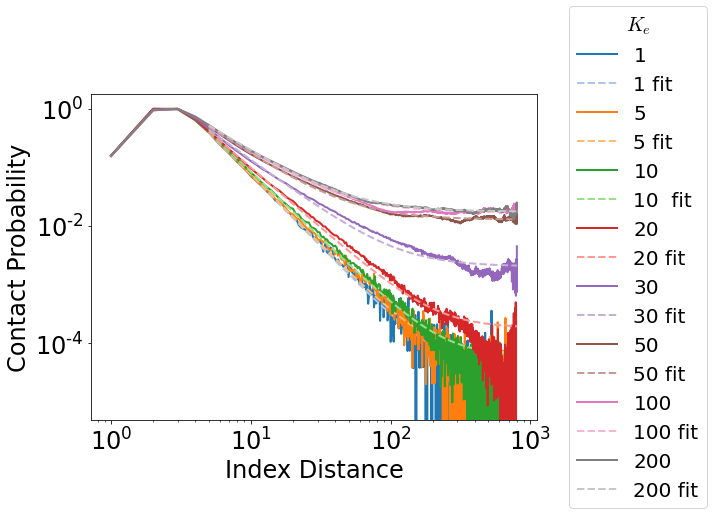

In [ ]:
data_path_list = [ 
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke1/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke2/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke5/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke10/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke20/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke50/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke100/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for data_path in data_path_list: 
    avg_cnt_list = []
    for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
        with h5py.File(dp, 'r') as h5_cnct:
            acm = h5_cnct['avg_connect_mat'][...]
            time_arr = h5_cnct['time'][...]

            avg_connect_vs_ind = np.zeros(acm.shape[0])
            for i in range(1, acm.shape[0]):
                avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                avg_connect_vs_ind[i] *= .5
            avg_cnt_list += [avg_connect_vs_ind]
    cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)
    cnt_vs_ind_arr /= np.amax(cnt_vs_ind_arr)
    x = np.arange(5,acm.shape[0])
    popt, pcov = curve_fit(power_law_func, x, cnt_vs_ind_arr[5:], p0=(5, -1, .1))

    _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:])
    _ = axarr.plot(x, power_law_func(x, *popt), ls='--')
    print(popt)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ = axarr.set_ylim(.00001, .05)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', labels=[1, "1 fit",
                                                                                      5,"5 fit", 
                                                                                      10, "10  fit",
                                                                                      20, "20 fit", 
                                                                                      30, "30 fit", 
                                                                                      50, "50 fit", 
                                                                                      100, "100 fit", 
                                                                                      200, "200 fit",
                                                                                      ])


[ 1.58690955e-01 -1.59587831e+00  3.04021377e-04]
[ 1.41877282e-01 -1.50520733e+00  4.09848068e-04]
[ 1.29148763e-01 -1.45568406e+00  4.94583742e-04]
[ 1.20611526e-01 -1.44673368e+00  5.50832985e-04]
[ 9.69382386e-02 -1.38992217e+00  5.60164235e-04]
[ 1.01783888e-01 -1.43797153e+00  5.95501933e-04]
[ 9.45403767e-02 -1.45976368e+00  6.18508233e-04]


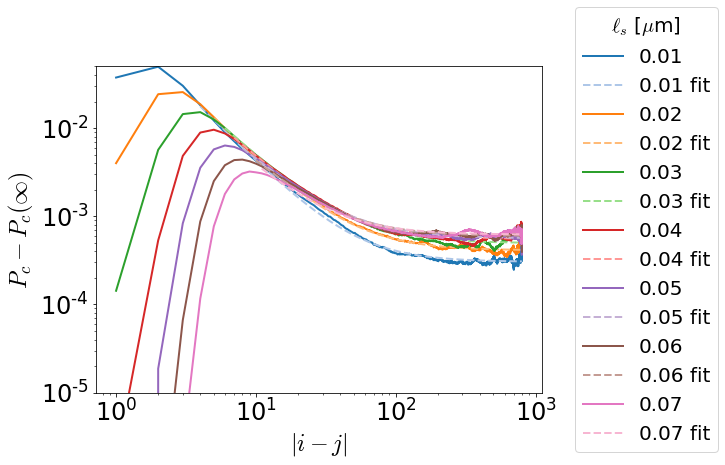

In [ ]:
data_path_list = [
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/',
                ]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


graph_connect_prob_vs_index(data_path_list, axarr)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$\ell_s$ [$\mu$m]', 
                 labels=['0.01','0.01 fit', 
                         '0.02', '0.02 fit', 
                         '0.03', '0.03 fit', 
                         '0.04', '0.04 fit', 
                         '0.05', '0.05 fit', 
                         '0.06', '0.06 fit', 
                         '0.07', '0.07 fit'])


[ 1.58690955e-01 -1.59587831e+00  3.04021377e-04]
[ 1.41877282e-01 -1.50520733e+00  4.09848068e-04]
[ 1.29148763e-01 -1.45568406e+00  4.94583742e-04]
[ 1.20611526e-01 -1.44673368e+00  5.50832985e-04]
[ 9.69382386e-02 -1.38992217e+00  5.60164235e-04]
[ 1.01783888e-01 -1.43797153e+00  5.95501933e-04]
[ 9.45403767e-02 -1.45976368e+00  6.18508233e-04]


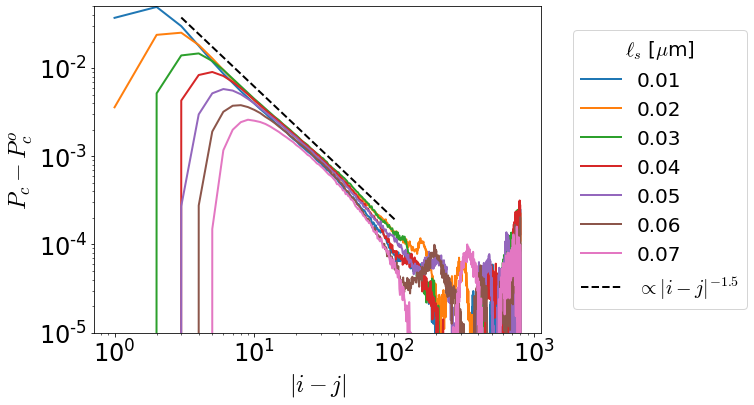

In [ ]:
data_path_list = [
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.01/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.03/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.04/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.05/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.06/',
                cond_path / '23-08-30_aLchr1_scan7.12_line800_KeVb28.35_kod3_Ls.1-.7nm_equil/simulations/Ls0.07/',
                ]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


graph_connect_prob_no_const(data_path_list, axarr)
_ = axarr.set_ylim(.00001, .05)
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$\ell_s$ [$\mu$m]', 
                 labels=['0.01',
                         '0.02', 
                         '0.03', 
                         '0.04', 
                         '0.05', 
                         '0.06', 
                         '0.07',
                         '$\propto |i-j|^{-1.5}$'])


[ 4.24284035e+01 -1.88091101e+00 -5.93110432e-04]
[18.03544902 -1.44474073  0.02884253]
[20.05808746 -1.45937333  0.07473076]
[18.12538121 -1.39542051  0.09999539]
[19.12819877 -1.41750676  0.11241977]
[14.90841734 -1.30702009  0.11465885]
[18.95022264 -1.40609907  0.13030916]
[17.81000755 -1.37740147  0.13279267]


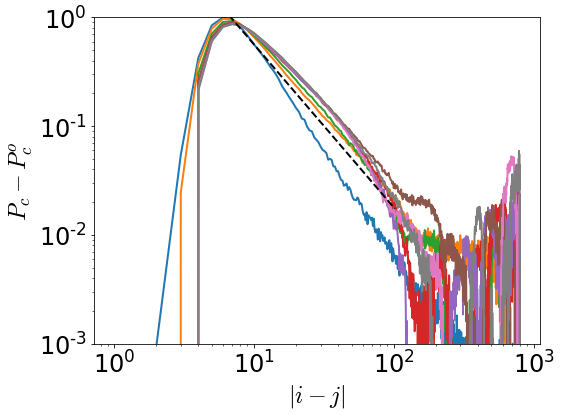

In [ ]:
data_path_list = [
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100/",
                cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_connect_prob_no_const(data_path_list, axarr, divide_by_time=True, divide_by_max=True)


### Old

/mnt/home/alamson/projects/analysis/aLENS_analysis/alens_analysis/chromatin/chrom_poly_stats.py:302: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return tmp.to_sparse_csr()


Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

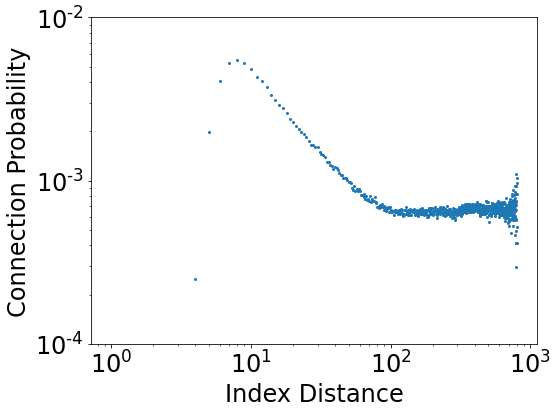

In [ ]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
# data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))


combined_connect_prob = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        n = 0
        syl_dat = h5_data['raw_data/sylinders'][:,:,0]
        bead_num = syl_dat.shape[0]
        avg_connect_prob = torch.zeros(bead_num).to(device)
        for t_ind in range(0, time_arr.size, 100):
            prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
            connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
            connect_prob = torch.zeros(bead_num).to(device)
            for i in range(1, bead_num):
                diag = torch.diagonal(connect_mat, i)
                connect_prob[i] = .5*diag.mean()
                diag = torch.diagonal(connect_mat, -i)
                connect_prob[i] += .5*diag.mean()
            n+=1
            avg_connect_prob += connect_prob
        avg_connect_prob /= float(n)
    combined_connect_prob.append(avg_connect_prob.to('cpu').numpy())
combined_connect_prob = np.array(combined_connect_prob).mean(axis=0)


fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, combined_connect_prob, label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)



[-0.98948778  0.04579563]


Text(20, 0.004, '$s^{-0.99}$')

Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


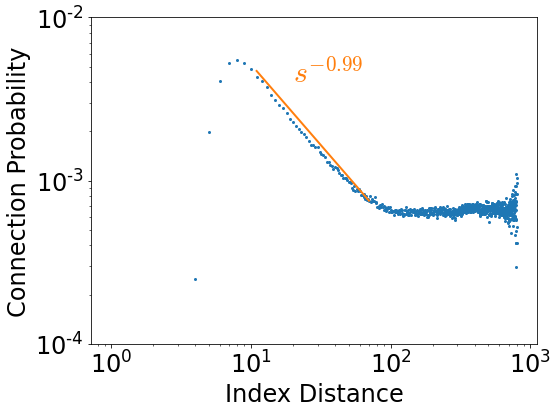

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
bead_ind_arr = np.arange(bead_num)+1
axarr.scatter(bead_ind_arr, combined_connect_prob, label=f'average')
# np.log(2*combined_connect_prob[10:80])
popt, pcov = curve_fit(lambda x, a, b: b*np.power(x,a), bead_ind_arr[10:70], combined_connect_prob[10:70], p0=(-2, 1))
print(popt)
axarr.plot(bead_ind_arr[10:70], 1.1*popt[1]*np.power(bead_ind_arr[10:70], popt[0]), label=f'average', c = 'tab:orange')
axarr.text(20, 0.004, f'$s^{{{popt[0]:.2f}}}$', fontsize=30, c = 'tab:orange')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')

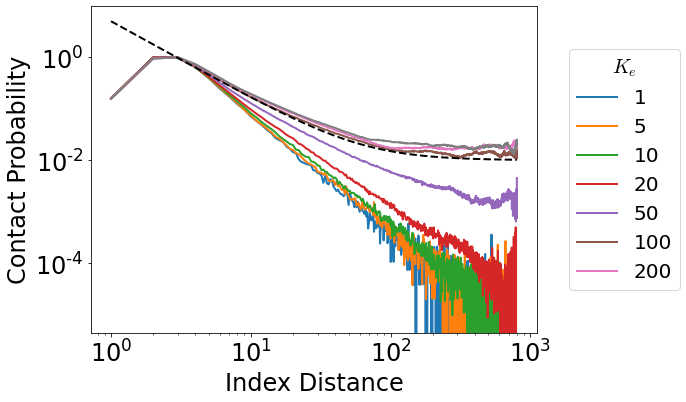

In [ ]:
data_path_list = [ 
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke1/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke2/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke5/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke10/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke20/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke50/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke100/",
                cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.02_Ke200/",
                ]
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

for data_path in data_path_list: 
    avg_cnt_list = []
    for dp in data_path.glob('s*/analysis/connect_diag_analysis.h5'):
        with h5py.File(dp, 'r') as h5_cnct:
            acm = h5_cnct['avg_connect_mat'][...]
            time_arr = h5_cnct['time'][...]

            avg_connect_vs_ind = np.zeros(acm.shape[0])
            for i in range(1, acm.shape[0]):
                avg_connect_vs_ind[i] += acm.diagonal(i).mean()
                avg_connect_vs_ind[i] += acm.diagonal(-i).mean()
                avg_connect_vs_ind[i] *= .5
            avg_cnt_list += [avg_connect_vs_ind]
    cnt_vs_ind_arr = np.asarray(avg_cnt_list).mean(axis=0)
    cnt_vs_ind_arr /= np.amax(cnt_vs_ind_arr)

    _ = axarr.plot(range(1,acm.shape[0]), cnt_vs_ind_arr[1:])
_ = axarr.plot(x, 5./np.power(x,1.5) + .01, c='k', ls='--')
_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ = axarr.set_ylim(.00001, .05)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5), title='$K_e$', labels=[1, 5, 10, 20, 50, 100, 200])


# Packing volume of beads

0.016104728747756425


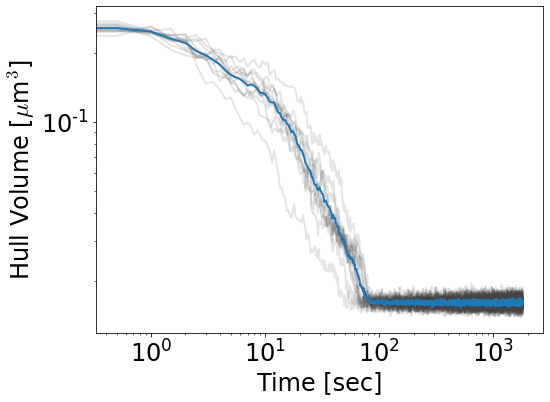

In [24]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print(hull_vol_list.mean(axis=0)[-2000:].mean())
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


In [28]:
(hull_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.01, 3))
(hull_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.075, 3))

np.power(hull_vol_list.mean(axis=0)[-2000:].mean()/800., 1./3.)

4.805900976299221

0.011391765277153713

0.027203271906133916

5.835703361763322e-05
4.188790204786391e-06
Ratio of packing volume to bead volume:  13.931715546639355
Ratio of packing volume to spring length (bead diameter not added):  0.08373683273712612
Ratio of packing volume to spring length (bead diameter added):  0.033023325740182186


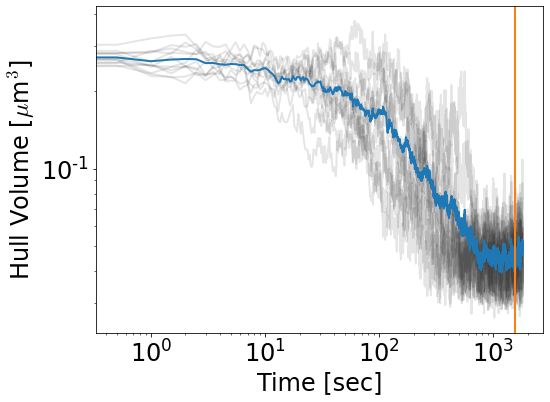

In [35]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", hull_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Ratio of packing volume to bead volume: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  5.835703361763322e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  13.931715546639355
Ratio of packing volume to spring length (bead diameter not added):  0.08373683273712612
Ratio of packing volume to spring length (bead diameter added):  0.033023325740182186
Ratio of packing volume to Ke:  0.007160847164590189


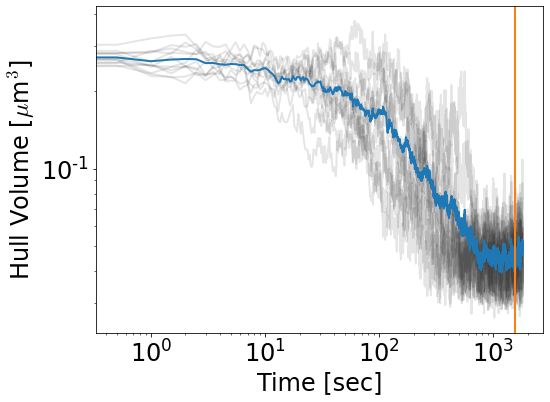

In [40]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", hull_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to Ke: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(5*ps.calc_sticky_search_volume(.075, 50)))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  2.014085571834992e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  4.808275118514084
Ratio of packing volume to spring length (bead diameter not added):  0.02890022610677136
Ratio of packing volume to spring length (bead diameter added):  0.011397392873514869
Ratio of packing volume to Ke:  0.0004119057596043481


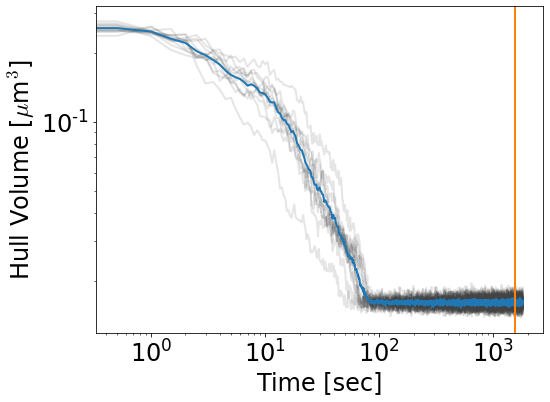

In [7]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", hull_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to Ke: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(30*ps.calc_sticky_search_volume(.075, 50)))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  5.835703361763322e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  13.931715546639355
Ratio of packing volume to spring length (bead diameter not added):  0.08373683273712612
Ratio of packing volume to spring length (bead diameter added):  0.033023325740182186
Ratio of packing volume to Ke:  0.007160847164590189


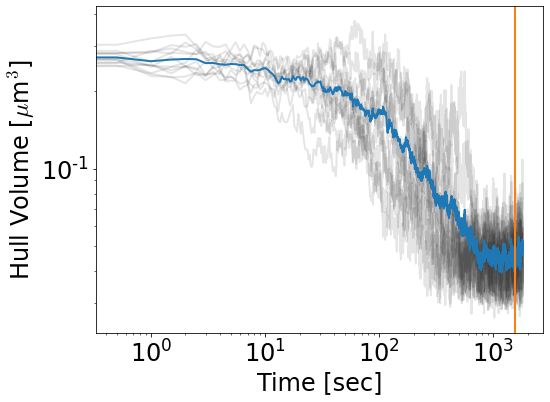

In [ ]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    hull_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        hull_vol = np.zeros(time_arr.size)
        for i in range(time_arr.size):
            hull = ConvexHull(com_arr[:,:, i])
            hull_vol[i] = hull.volume
        _ = axarr.plot(time_arr, hull_vol, color='k', alpha=.1)
        hull_vol_list += [hull_vol]
    
    hull_vol_list = np.array(hull_vol_list)
    _ = axarr.plot(time_arr, hull_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", hull_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to Ke: ", (hull_vol_list.mean(axis=0)[-500:].mean()/800.)/(5*ps.calc_sticky_search_volume(.075, 50)))
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  8.212290704250336e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  19.605399895335946
Ratio of packing volume to spring length (bead diameter not added):  0.11783861695168116
Ratio of packing volume to spring length (bead diameter added):  0.04647205901116671


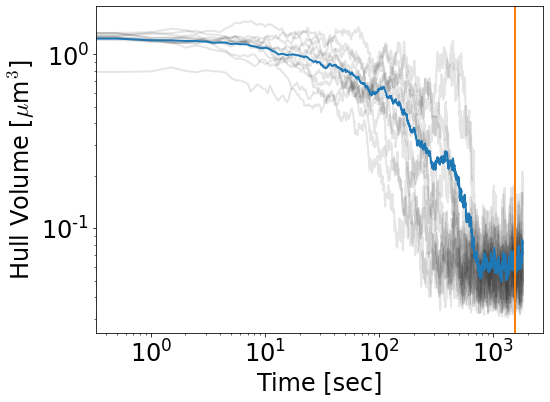

In [38]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  8.212290704250336e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  19.605399895335946
Ratio of packing volume to spring length (bead diameter not added):  0.11783861695168116
Ratio of packing volume to spring length (bead diameter added):  0.04647205901116671
Ratio of packing volume to Ke:  0.010077098673252682


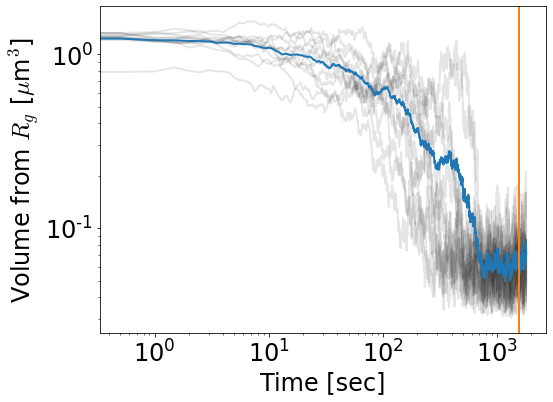

In [9]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Volume from $R_g$ [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to Ke: ", (sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(5*ps.calc_sticky_search_volume(.075, 50)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  2.0782724022865294e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Ratio of packing volume to bead volume:  4.9615098887305376
Ratio of packing volume to spring length (bead diameter not added):  0.029821246513782353
Ratio of packing volume to spring length (bead diameter added):  0.011760616032546464
Ratio of packing volume to Ke:  0.0004250327714470714


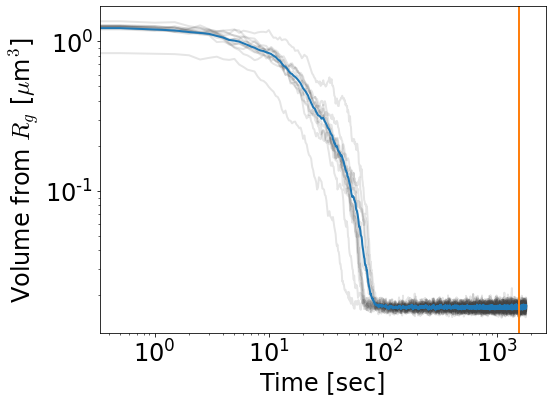

In [10]:
data_path = cond_path / "23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-500], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Volume from $R_g$ [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-500:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to Ke: ", (sphere_vol_list.mean(axis=0)[-500:].mean()/800.)/(30*ps.calc_sticky_search_volume(.075, 50)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  4.636740777641535e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Spring search volume:  0.00048040955814158704
Ratio of packing volume to bead volume:  11.069403218961133
Ratio of packing volume to spring length (bead diameter not added):  0.06653285180442457
Ratio of packing volume to spring length (bead diameter added):  0.026238585407907883
Ratio of packing volume to spring search volume:  0.09651641394434927


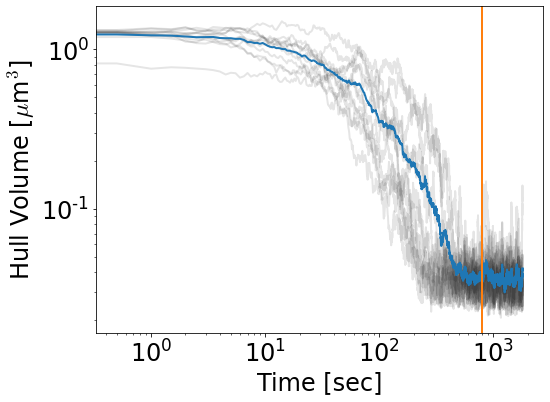

In [46]:
data_path = cond_path / "23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-2000], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Hull Volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Spring search volume: ", ps.calc_sticky_search_volume(.040, 50))
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to spring search volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(ps.calc_sticky_search_volume(.040, 50)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  2.1095711272209883e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Spring search volume:  0.00048040955814158704
Ratio of packing volume to bead volume:  5.036230090517428
Ratio of packing volume to spring length (bead diameter not added):  0.030270353662013097
Ratio of packing volume to spring length (bead diameter added):  0.011937730584930204
Ratio of packing volume to spring search volume:  0.04391193079883003


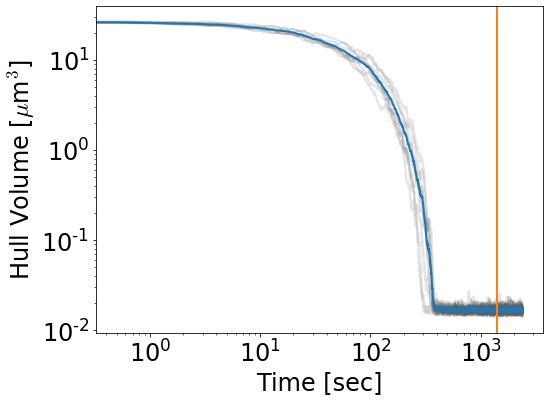

In [47]:
data_path = cond_path / "22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations/Ls0.02_Ke100/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-2000], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Globule volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Spring search volume: ", ps.calc_sticky_search_volume(.040, 50))
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to spring search volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(ps.calc_sticky_search_volume(.040, 50)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


Packing volume:  3.233954776078462e-05
Bead volume:  4.188790204786391e-06
Random packing bead volume:  6.596520007537624e-06
Spring search volume:  0.0002804014486194155
Ratio of packing volume to bead volume:  7.720498325227961
Ratio of packing volume to spring length (bead diameter not added):  0.0464041972966369
Ratio of packing volume to spring length (bead diameter added):  0.018300440474614432
Ratio of packing volume to spring search volume:  0.11533302670157952


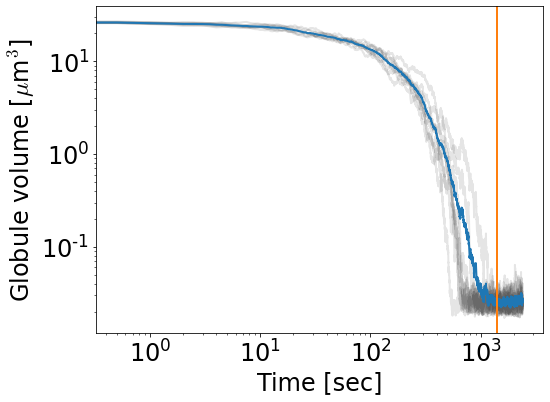

In [50]:
data_path = cond_path / "22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations/Ls0.01_Ke100/"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
try:
    sd_h5_data_lst = []
    for h5p in data_path.glob('s*/analysis/raw*.h5'):
        try:
            sd_h5_data_lst += [h5py.File(h5p, 'r')]
        except:
            print(f'Could not open {h5p}.')

    with h5py.File(next(data_path.glob('s*/analysis/raw*.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
    
    # bistress_ac_arrs = []
    # colstress_ac_arrs = []
    sphere_vol_list = []
    for h5_data in sd_h5_data_lst:
        time_arr = h5_data['time'][...]

        sy_dat = h5_data['raw_data/sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        rog = aa.calc_rad_of_gyration(com_arr)
        sphere_rad = np.power((5./3.)*rog*rog, .5)
        sphere_vol = (4./3.)*np.pi*np.power(sphere_rad, 3)
        _ = axarr.plot(time_arr, sphere_vol, color='k', alpha=.1)
        sphere_vol_list += [np.array(sphere_vol)]
    
    sphere_vol_list = np.array(sphere_vol_list)
    _ = axarr.plot(time_arr, sphere_vol_list.mean(axis=0))
    _ = axarr.axvline(time_arr[-2000], color='tab:orange')
    _ = axarr.set_xlabel('Time [sec]')
    _ = axarr.set_ylabel('Globule volume [$\mu$m$^3$]')
    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')

    print("Packing volume: ", sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)
    print("Bead volume: ", 4/3*np.pi*np.power(.01, 3))
    print("Random packing bead volume: ", 4/3*np.pi*np.power(.01, 3)/.635)
    print("Spring search volume: ", ps.calc_sticky_search_volume(.030, 50))
    print("Ratio of packing volume to bead volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.01, 3)))
    print("Ratio of packing volume to spring length (bead diameter not added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.055, 3)))
    print("Ratio of packing volume to spring length (bead diameter added): ",(sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(4/3*np.pi*np.power(.075, 3)))
    print("Ratio of packing volume to spring search volume: ", (sphere_vol_list.mean(axis=0)[-2000:].mean()/800.)/(ps.calc_sticky_search_volume(.030, 50)))
        
except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()


# Number of crosslinkers

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


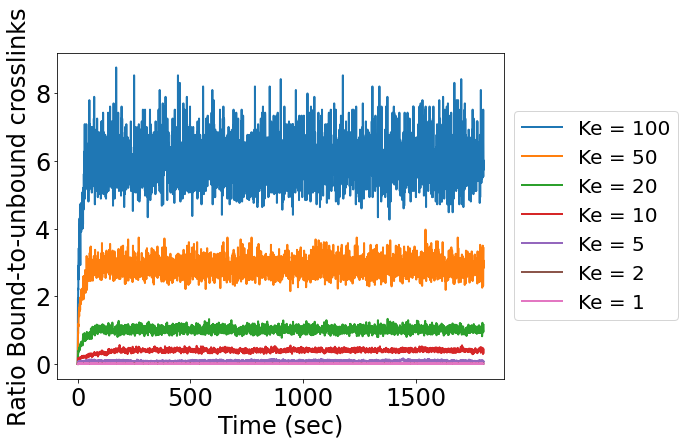

In [ ]:
data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke100/s1"
fig, ax = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 100')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke50/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 50')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke20/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 20')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke10/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 10')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke5/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 5')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke1/s2"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 2')

data_path = cond_path / "23-01-23_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200_equil/simulations/Ls0.05_Ke1/s1"
with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    prot_dat = h5_data['raw_data/proteins'][...]
    links = ((prot_dat[:,-1,:] >= 0).astype(float).sum(axis=0))
    links /= (800. - links)
    _ = ax.plot(time_arr, links, label='Ke = 1')

_ = ax.set_xlabel('Time (sec)')
_ = ax.set_ylabel('Ratio Bound-to-unbound crosslinks')

_ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 0.1], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 0.3], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, '

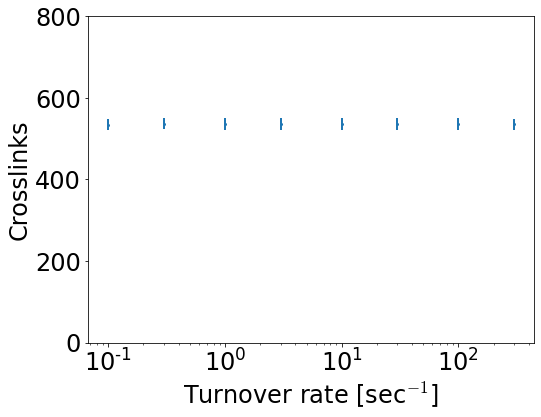

In [80]:
param_dirs = [
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod3",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod10",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod100",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        print(pparams)
        ko_arr += [pparams['proteins'][0]['ko_d'][1]] 
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(0, 800)
_ = axarr.set_xlabel('Turnover rate [sec$^{-1}$]')
_ = axarr.set_ylabel('Crosslinks')
# _ = axarr.set_xlabel('Index Distance')
# _ = axarr.set_ylabel('Average Distance')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.01, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0.0, 3.0], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.02, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0.0, 3.0], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'di

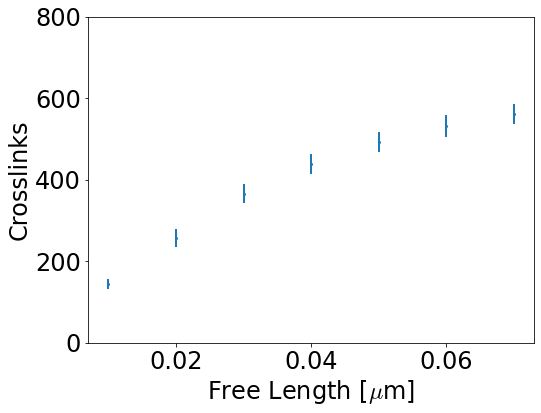

In [75]:
param_dirs = [
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.01',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07',
    ]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        print(pparams)
        ko_arr += [pparams['proteins'][0]['freeLength']]
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
# _ = axarr.set_xscale('log')
_ = axarr.set_ylim(0, 800)
_ = axarr.set_xlabel('Free Length [$\mu$m]')
_ = axarr.set_ylabel('Crosslinks')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[array([ 0,  0,  7, ...,  6, 10, 11])]
[array([  0,   0,  23, ...,  93,  92, 101])]
[array([  0,   0,  60, ..., 252, 257, 252])]
[array([  0,   0, 123, ..., 431, 446, 434])]
[array([  0,   0, 187, ..., 539, 539, 493])]
[array([  0,   0, 262, ..., 614, 625, 602])]
[array([  0,   0, 429, ..., 693, 702, 687])]
[array([  0,   0, 569, ..., 729, 750, 734])]
[9.273736812881733, 95.84314269850083, 249.90560799555803, 422.4575235980011, 513.7887284841754, 607.1757357023876, 693.3192670738479, 743.7731815657968]


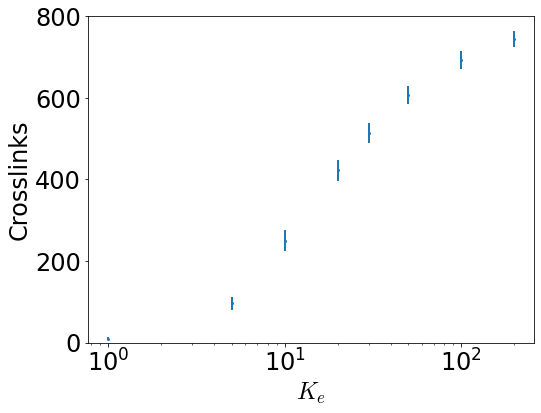

In [76]:
param_dirs = [
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200',
    ]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        # print(pparams)
        ko_arr += [pparams['proteins'][0]['Ke'][1]]
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        print(n_bound)
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

print(bound_avg)
_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlabel('$K_e$')
_ = axarr.set_ylabel('Crosslinks')
_ = axarr.set_ylim(0, 800)
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




# Contact probability vs parameter